In [71]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import os

from datetime import datetime, timedelta

from os import listdir, walk
from os.path import isfile, join

In [3]:
def calc_sec(time):
    hms = time.split(':')
    hms = [float(x) for x in hms]
    sec = hms[2] + hms[1]*60 + hms[0]*3600
    sec = round(sec,3)
    return sec

In [4]:
def calc_ts(sec):
    ts = ''
    hr = int(sec/3600)
    mn = int((sec - (hr*3600))/60)
    sc = sec - (hr*3600) - (mn*60)
    sc = round(sc,3)
    ts += str(hr) + ':' + str(mn) + ':' + str(sc)
    # print(ts)
    return ts

In [5]:
mypath = 'DDC_Data/'
nectec_dir = 'NECTEC_Data/'

In [57]:
%run nectec_calib.ipynb

min_values:  [1.793, 0.769, 4.863]
max_values:  [9.345, 8.449, 13.109]


In [72]:
def load_sensor_data(subject_id):
    sid_dir = mypath + subject_id
    sid_files = [f for f in listdir(sid_dir) if 'data' in f]

    filepath = sid_dir + '/' + sid_files[0]

    df_n = pd.read_csv(filepath, header=2, names=['sensor_id','timestamp','count','x','y','z',
                                                  'gyro_x','gyro_y','gyro_z','mag_x','mag_y','mag_z','mark'])

    df_n['timestamp'] = df_n['timestamp'].apply(lambda x: (datetime.utcfromtimestamp(x/1000) + timedelta(hours=7)).strftime('%Y-%m-%d %H:%M:%S.%f'))

    xyz_cols = ['x','y','z']
    k = 1000
    df_n['x'] = df_n['x'].apply(lambda x: -1*x/k)
    df_n['y'] = df_n['y'].apply(lambda x: -1*x/k)
    df_n['z'] = df_n['z'].apply(lambda x: x/k)
    
    min_norm = -1
    max_norm = 1
    
    df_norm = df_n.copy()
    for i in range(len(xyz_cols)):
        df_norm[xyz_cols[i]] = df_n[xyz_cols[i]].apply(lambda x: \
                                                    (x-min_vals[i])/(max_vals[i]-min_vals[i]) \
                                                    * (max_norm-min_norm) + min_norm)
    
    cols = ['timestamp','x','y','z']
    df = df_norm[cols].dropna()
    df = df.reset_index(drop=True)

#     df.to_csv(nectec_dir + subject_id + '-nectec.csv')
    
    return df

In [7]:
def load_timer(subject_id):
    sid_dir = mypath + subject_id
    sid_files = [f for f in listdir(sid_dir) if 'history_amdtimer' in f]
    
    timer_path = sid_dir + '/' + sid_files[0]
    
    df_timer = pd.read_csv(timer_path, header=None, names=['sid','raw_label', 'timestamp', 'duration','label'])

    filtered_timer = [i for i in df_timer['sid'] if i==int(subject_id)]

    timer_filt = df_timer[df_timer['sid'].isin(filtered_timer)]
    timer_filt = timer_filt.reset_index(drop=True)

    timer_arr = []

    for i in range(len(timer_filt)):
        if(timer_filt.loc[i]['raw_label']=='upstairs' or 
          timer_filt.loc[i]['raw_label']=='downstairs'):
            timer_arr.append('walk')
        else:
            timer_arr.append(timer_filt.loc[i]['raw_label'])

    timer_filt['label'] = pd.Series(timer_arr)

    save_dir = nectec_dir + subject_id + '/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    timer_filt.to_csv(save_dir + subject_id + '-timer.csv')

    return timer_filt

In [80]:
# all_subjects = [str(i) for i in range(4001,4002)]
all_subjects = [str(i) for i in range(3001,3006)]

In [83]:
for sid in all_subjects:
    print(sid)
    df = load_sensor_data(sid)
    
    df.to_csv(nectec_dir + sid + '/' + sid + '-nectec.csv')

3001
3002
3003
3004
3005


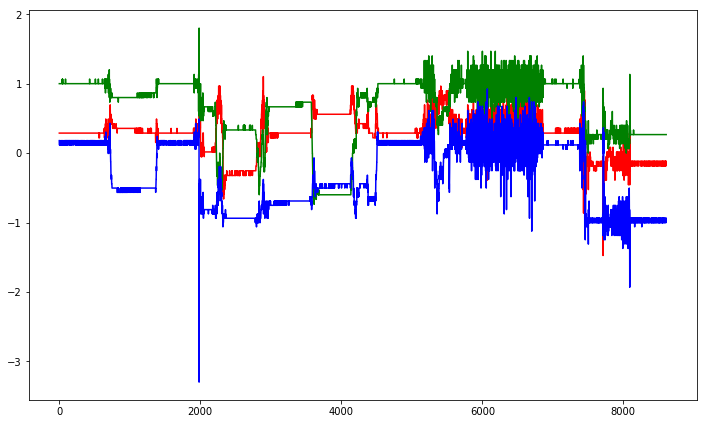

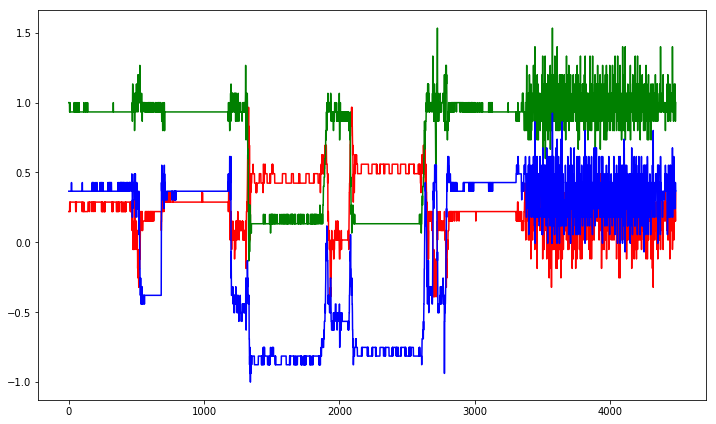

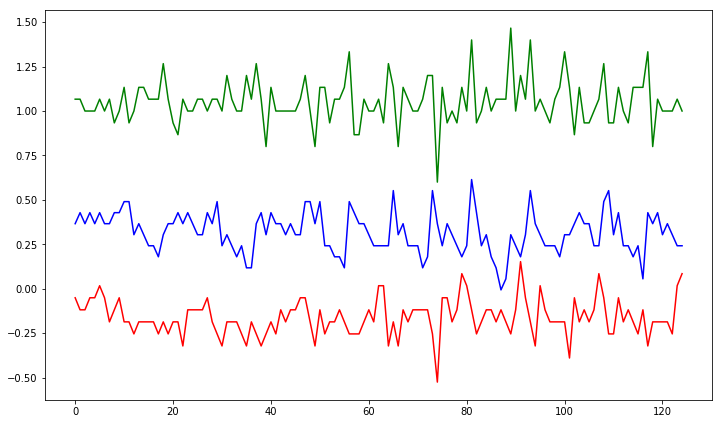

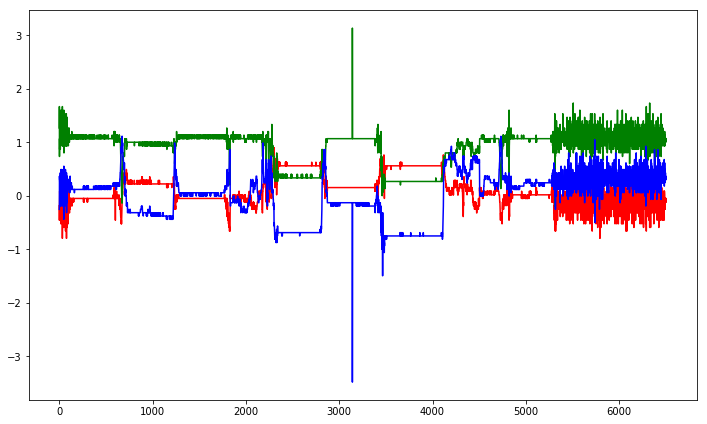

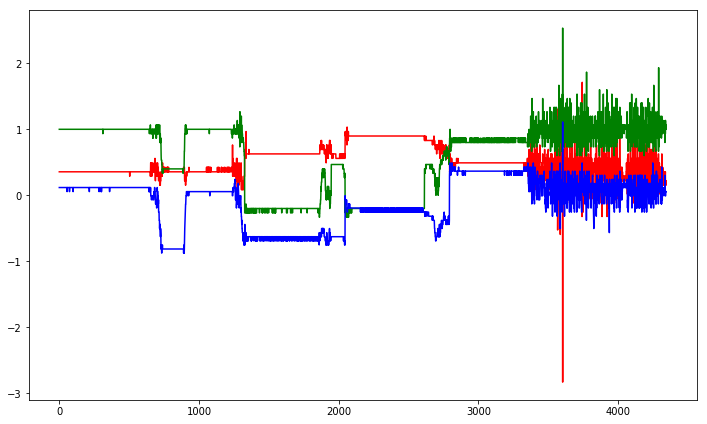

In [84]:
for sid in all_subjects:
    df = pd.read_csv(nectec_dir + sid + '/' + sid + '-nectec.csv')
    
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    f.tight_layout()
    ax.plot(df['x'], color='r')
    ax.plot(df['y'], color='g')
    ax.plot(df['z'], color='b')

    plt.show()